In [1]:
import os
os.chdir('..')
from team_functions import *
from models import *

In [2]:
today = date.today()
print(f'Today is: {today}')

Today is: 2024-02-20


In [3]:
tonight_odds = pd.read_excel('Predictions/games_odds.xlsx', sheet_name='Tonight')
prev_odds = pd.read_excel('Predictions/games_odds.xlsx', sheet_name='Previous')

In [4]:
prev_odds.tail()

,date,visitor,local,v_line,l_line,Results
77,2024-02-14,LAL,UTA,2.700000,1.487805,1
78,2024-02-14,LAC,GSW,2.200000,1.704225,1
79,2024-02-15,MIL,MEM,1.142857,6.000000,0
80,2024-02-15,GSW,UTA,1.800000,2.050000,1
81,2024-02-15,MIN,POR,1.235294,4.300000,1


In [5]:
games_to_pred = []
teams, opps = prev_odds['visitor'], prev_odds['local']
for team, opp in zip(teams, opps):
    team_row = {}
    team_df = pd.read_excel(f'data/CurrentSeason/{team}.xlsx')
    
    team_row['Game'] = team_df['Game'].iloc[-1] + 1
    team_row['Date'] = prev_odds.loc[prev_odds['visitor'] == team, 'date'].iloc[0]
    team_row['Streak'] = team_df['Streak'].iloc[-1]

    team_cols = ['Pts', 'Pace', 'eFG', 'TOV', 'ORB', 'FTR', 'ORT']
    for col in team_cols:
        team_row[col] = team_df[col].mean()

    opp_df = pd.read_excel(f'data/CurrentSeason/{opp}.xlsx')
    team_row['OppID'] = mapTeamID(opp)
    
    opp_cols = ['Pts', 'eFG', 'TOV', 'ORB', 'FTR', 'ORT']
    for col in opp_cols:
        team_row['Opp'+col] = opp_df[col].mean()
        
    team_row['Location'] = 0
    
    team_row['Month'] = team_row['Date'].month
    team_row['DayOfWeek'] = team_row['Date'].weekday()
    team_row['DaysOfRest'] = (team_row['Date'] - team_df['Date'].iloc[-1]).days
    
    team_row['TeamID'] = mapTeamID(team)
    team_row['Season'] = 2024
    
    games_to_pred.append(team_row)
    
games_df = pd.DataFrame(games_to_pred)

In [6]:
games_df

,Game,Date,Streak,Pts,Pace,eFG,TOV,ORB,FTR,ORT,...,OppTOV,OppORB,OppFTR,OppORT,Location,Month,DayOfWeek,DaysOfRest,TeamID,Season
0,55,2024-02-03,-2,113.351852,97.005556,0.538056,10.570370,24.981481,0.178370,116.107407,...,10.016667,25.075926,0.247741,120.216667,0,2,5,-11,3,2024
1,54,2024-02-03,1,119.735849,99.077358,0.558377,11.930189,27.469811,0.193264,119.524528,...,10.903636,27.734545,0.219945,119.565455,0,2,5,-12,10,2024
2,55,2024-02-03,1,118.407407,99.325926,0.563796,11.309259,23.253704,0.177167,118.003704,...,10.690909,24.361818,0.188182,115.529091,0,2,5,-11,26,2024
3,57,2024-02-03,3,117.000000,100.319643,0.559661,11.892857,19.608929,0.219786,115.710714,...,10.990909,29.432727,0.204764,119.514545,0,2,5,-11,14,2024
4,57,2024-02-03,-2,122.017857,100.771429,0.573571,11.041071,21.851786,0.222518,120.405357,...,10.716364,22.247273,0.201509,118.925455,0,2,5,-12,17,2024
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
77,57,2024-02-03,3,117.000000,100.319643,0.559661,11.892857,19.608929,0.219786,115.710714,...,13.012500,29.253571,0.211625,117.789286,0,2,5,-11,14,2024
78,54,2024-02-14,1,118.264151,97.177358,0.569472,11.088679,24.662264,0.220736,121.486792,...,11.930189,27.469811,0.193264,119.524528,0,2,2,0,13,2024
79,57,2024-02-03,-2,122.017857,100.771429,0.573571,11.041071,21.851786,0.222518,120.405357,...,12.530357,21.703571,0.181036,108.837500,0,2,5,-12,17,2024
80,54,2024-02-03,1,119.735849,99.077358,0.558377,11.930189,27.469811,0.193264,119.524528,...,13.012500,29.253571,0.211625,117.789286,0,2,5,-12,10,2024


In [7]:
import joblib
import torch

In [8]:
import matplotlib.pyplot as plt

In [11]:
def makeModelPredictions(games_df, odds_df, model_name='NN', nn_name='FCNN', show=True):
    if model_name == 'NN':
        if nn_name == 'FCNN':
            fcnns = pd.read_excel('Models/TrainedModels/FCNNs/models.xlsx')
            fcnns = fcnns.sort_values(by='Accuracy', ascending=False, ignore_index=True)

            model_file = fcnns.iloc[0]['File']

            model = torch.load('Models/'+model_file)
        elif nn_name == 'RNN':
            rnns =  pd.read_excel('Models/TrainedModels/Recurrents/models.xlsx')
            rnns = rnns.sort_values(by='Accuracy', ascending=False, ignore_index=True)

            model_file = rnns.iloc[0]['File']

            model = torch.load('Models/'+model_file)
        
        scaler = joblib.load(f'Models/Scalers/{nn_name}.pkl')
        
    else:
        model = joblib.load(f'Models/TrainedModels/{model_name}_Model.pkl')
        scaler = joblib.load(f'Models/Scalers/{model_name}.bin')
        
    
    scaled_df = scaler.transform(games_df.drop(columns=['Date']))
    if model_name == 'NN':
        scaled_df = torch.FloatTensor(scaled_df)
        predictions = torch.round(model(scaled_df).squeeze(1))
        predictions = predictions.detach().numpy()
    else:
        predictions = model.predict(scaled_df)
    
    odds_df['Predictions'] = predictions
    if show:
        print(f'Predictions made by: {model_name}')
        display(odds_df.head())
        
    return odds_df

Predictions made by: NN


,date,visitor,local,v_line,l_line,Results,Predictions
0,2024-02-03,BRK,PHI,2.420000,1.588235,1,0.0
1,2024-02-03,GSW,ATL,2.200000,1.704225,0,1.0
2,2024-02-03,SAC,CHI,2.050000,1.800000,1,1.0
3,2024-02-03,LAL,NYK,2.640000,1.505051,1,1.0
4,2024-02-03,MIL,DAL,1.540541,2.540000,1,1.0


# of bets win: 57
% of bets win: 68.67469879518072
Final Balance: 126.98475464274146


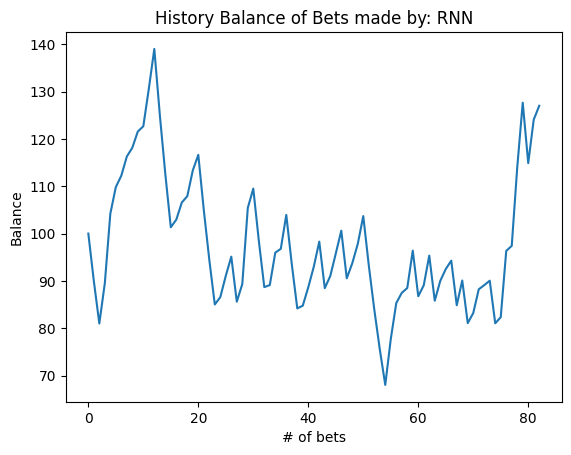

In [12]:
model_name = 'RNN'
model_preds = makeModelPredictions(games_df, prev_odds, model_name='NN', nn_name=model_name)

balance = 100
history = [balance]
n_wins = 0
win_history = [n_wins]

for game_idx in range(model_preds.shape[0]):
    row = prev_odds.iloc[game_idx]
    
    prediction = row['Predictions']
    result = row['Results']
    
    if prediction == 1:
        line = row['v_line']
    elif prediction == 0:
        line = row['l_line']
    
    bet = balance * 0.1
    balance -= bet
    if prediction == result:
        income = bet*line
        balance += income
        n_wins += 1
        
    win_history.append(n_wins)
    history.append(balance)
    
history_df = pd.DataFrame({'Date': [today]*len(history), 'Balance': history, 'Wins': win_history})
history_df.to_excel(f'Predictions/ModelsHistory/{model_name}.xlsx', index=0) 

plt.xlabel('# of bets')
plt.ylabel('Balance')
plt.title(f'History Balance of Bets made by: {model_name}')
plt.plot(history)
print(f'# of bets win: {win_history[-1]}')
print(f'% of bets win: {(win_history[-1]/len(win_history))*100}')
print(f'Final Balance: {history[-1]}')

Predictions made by: FCNN


,date,visitor,local,v_line,l_line,Results,Predictions
0,2024-02-03,BRK,PHI,2.420000,1.588235,1,0.0
1,2024-02-03,GSW,ATL,2.200000,1.704225,0,0.0
2,2024-02-03,SAC,CHI,2.050000,1.800000,1,0.0
3,2024-02-03,LAL,NYK,2.640000,1.505051,1,0.0
4,2024-02-03,MIL,DAL,1.540541,2.540000,1,0.0
5,2024-02-03,CLE,SAS,1.219780,4.500000,1,1.0
6,2024-02-04,ORL,DET,1.359712,3.250000,1,0.0
7,2024-02-04,PHO,WAS,1.160000,5.550000,1,1.0
8,2024-02-06,HOU,IND,3.750000,1.289855,0,0.0
9,2024-02-06,MEM,NYK,8.000000,1.090909,0,0.0


# of bets win: 12
% of bets win: 52.17391304347826
Final Balance: 63.55859416615098


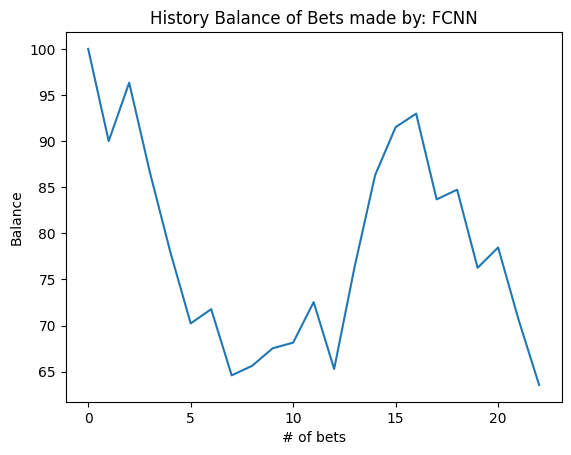

In [10]:
model_name = 'FCNN'
model_preds = makeModelPredictions(games_df, prev_odds, model_name)

balance = 100
history = [balance]
n_wins = 0
win_history = [n_wins]

for game_idx in range(model_preds.shape[0]):
    row = prev_odds.iloc[game_idx]
    
    prediction = row['Predictions']
    result = row['Results']
    
    if prediction == 1:
        line = row['v_line']
    elif prediction == 0:
        line = row['l_line']
    
    bet = balance * 0.1
    balance -= bet
    if prediction == result:
        income = bet*line
        balance += income
        n_wins += 1
        
    win_history.append(n_wins)
    history.append(balance)
    
history_df = pd.DataFrame({'Date': [today]*len(history), 'Balance': history, 'Wins': win_history})
history_df.to_excel(f'Predictions/ModelsHistory/{model_name}.xlsx', index=0) 

plt.xlabel('# of bets')
plt.ylabel('Balance')
plt.title(f'History Balance of Bets made by: {model_name}')
plt.plot(history)
print(f'# of bets win: {win_history[-1]}')
print(f'% of bets win: {(win_history[-1]/len(win_history))*100}')
print(f'Final Balance: {history[-1]}')

Predictions made by: LR


,date,visitor,local,v_line,l_line,Results,Predictions
0,2024-02-03,BRK,PHI,2.420000,1.588235,1,0
1,2024-02-03,GSW,ATL,2.200000,1.704225,0,0
2,2024-02-03,SAC,CHI,2.050000,1.800000,1,0
3,2024-02-03,LAL,NYK,2.640000,1.505051,1,0
4,2024-02-03,MIL,DAL,1.540541,2.540000,1,0
5,2024-02-03,CLE,SAS,1.219780,4.500000,1,1
6,2024-02-04,ORL,DET,1.359712,3.250000,1,0
7,2024-02-04,PHO,WAS,1.160000,5.550000,1,1
8,2024-02-06,HOU,IND,3.750000,1.289855,0,0
9,2024-02-06,MEM,NYK,8.000000,1.090909,0,0


# of bets win: 13
% of bets win: 56.52173913043478
Final Balance: 68.86249148821811


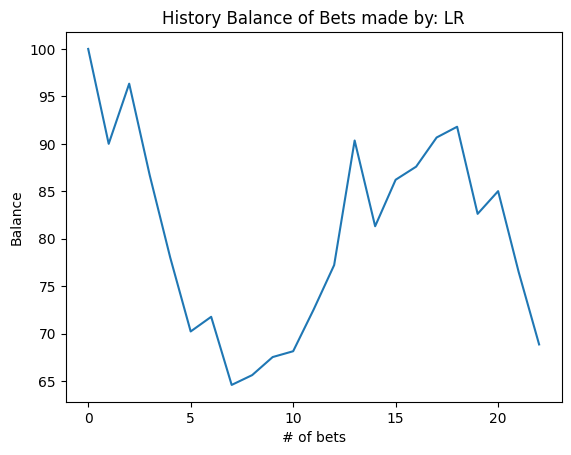

In [11]:
model_name = 'LR'
model_preds = makeModelPredictions(games_df, prev_odds, model_name)

balance = 100
history = [balance]
n_wins = 0
win_history = [n_wins]

for game_idx in range(model_preds.shape[0]):
    row = prev_odds.iloc[game_idx]
    
    prediction = row['Predictions']
    result = row['Results']
    
    if prediction == 1:
        line = row['v_line']
    elif prediction == 0:
        line = row['l_line']
    
    bet = balance * 0.1
    balance -= bet
    if prediction == result:
        income = bet*line
        balance += income
        n_wins += 1
        
    win_history.append(n_wins)
    history.append(balance)
    
history_df = pd.DataFrame({'Date': [today]*len(history), 'Balance': history, 'Wins': win_history})
history_df.to_excel(f'Predictions/ModelsHistory/{model_name}.xlsx', index=0) 

plt.xlabel('# of bets')
plt.ylabel('Balance')
plt.title(f'History Balance of Bets made by: {model_name}')
plt.plot(history)
print(f'# of bets win: {win_history[-1]}')
print(f'% of bets win: {(win_history[-1]/len(win_history))*100}')
print(f'Final Balance: {history[-1]}')

Predictions made by: RF


,date,visitor,local,v_line,l_line,Results,Predictions
0,2024-02-03,BRK,PHI,2.420000,1.588235,1,0
1,2024-02-03,GSW,ATL,2.200000,1.704225,0,0
2,2024-02-03,SAC,CHI,2.050000,1.800000,1,1
3,2024-02-03,LAL,NYK,2.640000,1.505051,1,0
4,2024-02-03,MIL,DAL,1.540541,2.540000,1,0
5,2024-02-03,CLE,SAS,1.219780,4.500000,1,1
6,2024-02-04,ORL,DET,1.359712,3.250000,1,0
7,2024-02-04,PHO,WAS,1.160000,5.550000,1,1
8,2024-02-06,HOU,IND,3.750000,1.289855,0,0
9,2024-02-06,MEM,NYK,8.000000,1.090909,0,0


# of bets win: 13
% of bets win: 56.52173913043478
Final Balance: 69.03754596994743


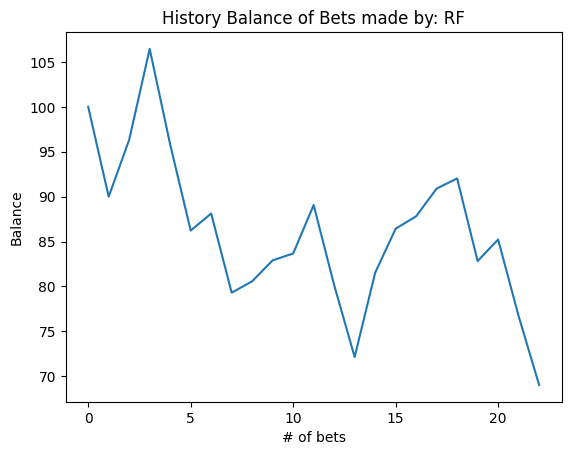

In [12]:
model_name = 'RF'
model_preds = makeModelPredictions(games_df, prev_odds, model_name)

balance = 100
history = [balance]
n_wins = 0
win_history = [n_wins]

for game_idx in range(model_preds.shape[0]):
    row = prev_odds.iloc[game_idx]
    
    prediction = row['Predictions']
    result = row['Results']
    
    if prediction == 1:
        line = row['v_line']
    elif prediction == 0:
        line = row['l_line']
    
    bet = balance * 0.1
    balance -= bet
    if prediction == result:
        income = bet*line
        balance += income
        n_wins += 1
        
    win_history.append(n_wins)
    history.append(balance)
    
history_df = pd.DataFrame({'Date': [today]*len(history), 'Balance': history, 'Wins': win_history})
history_df.to_excel(f'Predictions/ModelsHistory/{model_name}.xlsx', index=0)

plt.xlabel('# of bets')
plt.ylabel('Balance')
plt.title(f'History Balance of Bets made by: {model_name}')
plt.plot(history)
print(f'# of bets win: {win_history[-1]}')
print(f'% of bets win: {(win_history[-1]/len(win_history))*100}')
print(f'Final Balance: {history[-1]}')

Predictions made by: GB


,date,visitor,local,v_line,l_line,Results,Predictions
0,2024-02-03,BRK,PHI,2.420000,1.588235,1,0
1,2024-02-03,GSW,ATL,2.200000,1.704225,0,0
2,2024-02-03,SAC,CHI,2.050000,1.800000,1,1
3,2024-02-03,LAL,NYK,2.640000,1.505051,1,0
4,2024-02-03,MIL,DAL,1.540541,2.540000,1,0
5,2024-02-03,CLE,SAS,1.219780,4.500000,1,1
6,2024-02-04,ORL,DET,1.359712,3.250000,1,0
7,2024-02-04,PHO,WAS,1.160000,5.550000,1,1
8,2024-02-06,HOU,IND,3.750000,1.289855,0,0
9,2024-02-06,MEM,NYK,8.000000,1.090909,0,0


# of bets win: 13
% of bets win: 56.52173913043478
Final Balance: 65.03679751665042


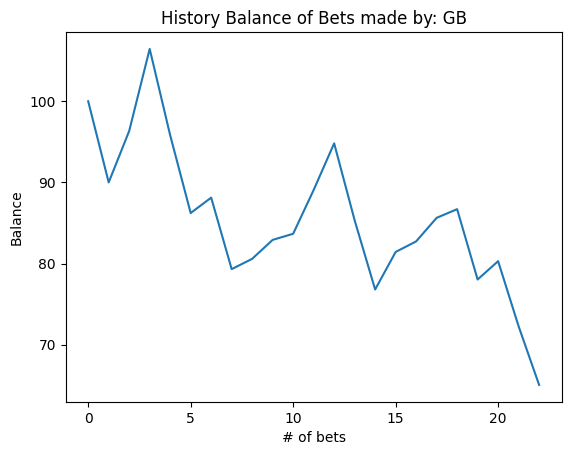

In [13]:
model_name = 'GB'
model_preds = makeModelPredictions(games_df, prev_odds, model_name)

balance = 100
history = [balance]
n_wins = 0
win_history = [n_wins]

for game_idx in range(model_preds.shape[0]):
    row = prev_odds.iloc[game_idx]
    
    prediction = row['Predictions']
    result = row['Results']
    
    if prediction == 1:
        line = row['v_line']
    elif prediction == 0:
        line = row['l_line']
    
    bet = balance * 0.1
    balance -= bet
    if prediction == result:
        income = bet*line
        balance += income
        n_wins += 1
        
    win_history.append(n_wins)
    history.append(balance)
    
history_df = pd.DataFrame({'Date': [today]*len(history), 'Balance': history, 'Wins': win_history})
history_df.to_excel(f'Predictions/ModelsHistory/{model_name}.xlsx', index=0)

plt.xlabel('# of bets')
plt.ylabel('Balance')
plt.title(f'History Balance of Bets made by: {model_name}')
plt.plot(history)
print(f'# of bets win: {win_history[-1]}')
print(f'% of bets win: {(win_history[-1]/len(win_history))*100}')
print(f'Final Balance: {history[-1]}')

Predictions made by: SVM


,date,visitor,local,v_line,l_line,Results,Predictions
0,2024-02-03,BRK,PHI,2.420000,1.588235,1,0
1,2024-02-03,GSW,ATL,2.200000,1.704225,0,0
2,2024-02-03,SAC,CHI,2.050000,1.800000,1,0
3,2024-02-03,LAL,NYK,2.640000,1.505051,1,0
4,2024-02-03,MIL,DAL,1.540541,2.540000,1,0
5,2024-02-03,CLE,SAS,1.219780,4.500000,1,1
6,2024-02-04,ORL,DET,1.359712,3.250000,1,0
7,2024-02-04,PHO,WAS,1.160000,5.550000,1,1
8,2024-02-06,HOU,IND,3.750000,1.289855,0,0
9,2024-02-06,MEM,NYK,8.000000,1.090909,0,0


# of bets win: 13
% of bets win: 56.52173913043478
Final Balance: 73.09857808582669


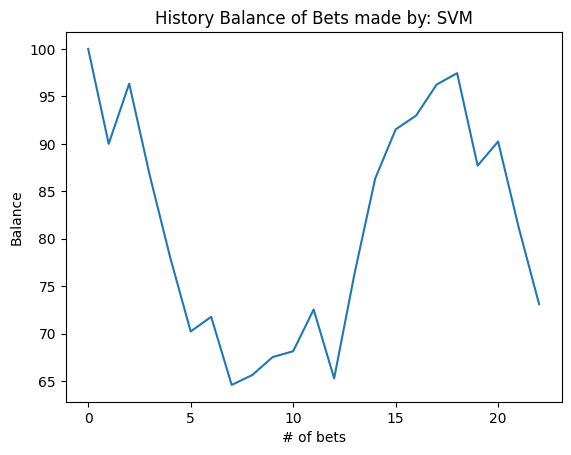

In [14]:
model_name = 'SVM'
model_preds = makeModelPredictions(games_df, prev_odds, model_name)

balance = 100
history = [balance]
n_wins = 0
win_history = [n_wins]

for game_idx in range(model_preds.shape[0]):
    row = prev_odds.iloc[game_idx]
    
    prediction = row['Predictions']
    result = row['Results']
    
    if prediction == 1:
        line = row['v_line']
    elif prediction == 0:
        line = row['l_line']
    
    bet = balance * 0.1
    balance -= bet
    if prediction == result:
        income = bet*line
        balance += income
        n_wins += 1
        
    win_history.append(n_wins)
    history.append(balance)
    
history_df = pd.DataFrame({'Date': [today]*len(history), 'Balance': history, 'Wins': win_history})
history_df.to_excel(f'Predictions/ModelsHistory/{model_name}.xlsx', index=0)

plt.xlabel('# of bets')
plt.ylabel('Balance')
plt.title(f'History Balance of Bets made by: {model_name}')
plt.plot(history)
print(f'# of bets win: {win_history[-1]}')
print(f'% of bets win: {(win_history[-1]/len(win_history))*100}')
print(f'Final Balance: {history[-1]}')